# CPSC 330 - Applied Machine Learning 

## Homework 7: Clustering and recommender systems
### Associated lectures: Lecture 14 and 15

**Due date: Wednesday March 22, at 11:59pm**


In [119]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option("display.max_colwidth", 0)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1: Document clustering toy example <a name="1"></a>
<hr>

In lecture 14, we looked at a popular application of clustering: customer segmentation. In this lab, we will work on another popular application, [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A), and clustering is a commonly used technique to organize this data in a meaningful way. 

In this exercise, we will create a toy dataset with sentences from Wikipedia articles and cluster these sentences. In the next exercise, we'll move to a real corpus.  

### 1.1 Sample sentences from Wikipedia articles
rubric={points:4}

The code below extracts first sentences of Wikipedia articles on a set of queries. You will need the `wikipedia` package installed in the course environment to run the code below. 

```conda install -c conda-forge wikipedia```

**Your tasks:**

Run the code below and answer the following question. 

1. Given this dataset, how many clusters would you expect a clustering algorithm to identify? How would you label these clusters?   

> *Note 1: If you have created `conda` environment using [the course `yml` file](https://github.ubc.ca/MDS-2020-21/DSCI_563_unsup-learn_students/blob/master/env-dsci-563.yml), you should have the following packages. If not, you may have to install appropriate packages in our course's environment.*

> *Note 2: Feel free to experiment with queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs when they grade your submission.*


In [60]:
import wikipedia
from nltk.tokenize import sent_tokenize, word_tokenize

queries = [
    "Mount Everests",
    "Raspberry",
    "Mount Denali",
    "Arithmetic",
    "Topology",
    "Baseball",
    "Hockey",
    "Mango_fruit",
    "Mount Kenya",
    "Football",
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    sent = sent_tokenize(wikipedia.page(queries[i]).content)[0]
    wiki_dict["text"].append(sent)
    wiki_dict["n_words"].append(len(word_tokenize(sent)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,Mount Everests,"Mount Everest (Nepali: सगरमाथा, romanized: Sagarmāthā; Tibetan: Chomolungma ཇོ་མོ་གླང་མ; Chinese: 珠穆朗玛峰; pinyin: Zhūmùlǎngmǎ Fēng) is Earth's highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas.",44
1,Raspberry,"The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.",30
2,Mount Denali,"Denali (; also known as Mount McKinley, its former official name) is the highest mountain peak in North America, with a summit elevation of 20,310 feet (6,190 m) above sea level.",38
3,Arithmetic,"Arithmetic (from Ancient Greek ἀριθμός (arithmós) 'number', and τική [τέχνη] (tikḗ [tékhnē]) 'art, craft') is an elementary part of mathematics that consists of the study of the properties of the traditional operations on numbers—addition, subtraction, multiplication, division, exponentiation, and extraction of roots.",62
4,Topology,"In mathematics, topology (from the Greek words τόπος, 'place, location' and λόγος, 'study') concerns with the properties of a geometric object that are preserved under continuous deformations, such as stretching, twisting, crumpling, and bending; that is, without closing holes, opening holes, tearing, gluing, or passing through itself.",66
5,Baseball,"Basketball is a team sport in which two teams, most commonly of five players each, opposing one another on a rectangular court, compete with the primary objective of shooting a basketball (approximately 9.4 inches (24 cm) in diameter) through the defender's hoop (a basket 18 inches (46 cm) in diameter mounted 10 feet (3.048 m) high to a backboard at each end of the court), while preventing the opposing team from shooting through their own hoop.",92
6,Hockey,"Hockey is a term used to denote a family of various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.",40
7,Mango_fruit,A mango is an edible stone fruit produced by the tropical tree Mangifera indica.,15
8,Mount Kenya,"Mount Kenya (Kikuyu: Kĩrĩnyaga, Kamba, Ki Nyaa) is the highest mountain in Kenya and the second-highest in Africa, after Kilimanjaro.",27
9,Football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22


### BEGIN SOLUTION

I would expect a clustering algorithm to identify 4 clusters: mountains, fruits, mathematics, and sports. 

### END SOLUTION

<br><br>

### 1.2 `KMeans` with bag-of-words representation 
rubric={points:10}

We have seen that before we pass text to machine learning models, we need to encode it into a numeric representation. So let's encode our toy dataset above (`wiki_df`) to a numeric representation. 

First, let's try our good old friend: bag-of-words representation. The code below creates dense bag-of-words representation of Wikipedia sentences from question 1.1 using a [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 

**Your tasks:**

Run the code below and answer the following questions. 

1. Modify the `CountVectorizer` to ignore words appearing in only one data point (or document, one row of `wiki_df`).
2. Run `KMeans` clustering on the transformed data (`bow_sents`) with K = the number of clusters you identified in 1.1.  
3. Examine clustering labels assigned by `KMeans`. Is `KMeans` doing a reasonable job in clustering the sentences? 

> You can access cluster label assignments using `labels_` attribute of the clustering object. 

In [61]:
vec = CountVectorizer(stop_words='english')
bow_sents = vec.fit_transform(wiki_df["text"]).todense()
bow_df = pd.DataFrame(
    data=bow_sents, columns=vec.get_feature_names_out(), index=wiki_df.index
)
bow_df

,048,10,18,190,20,24,310,46,addition,africa,...,winter,words,zhūmùlǎngmǎ,λόγος,τέχνη,τική,τόπος,सगरम,ἀριθμός,珠穆朗玛峰
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
5,1,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### BEGIN SOLUTION for 1.2.2 and 1.2.3

In [64]:
kmeans_bow_hd = KMeans(n_clusters=4, random_state=42)
kmeans_bow.fit(bow_sents)
wiki_df

,wiki query,text,n_words
0,Mount Everests,"Mount Everest (Nepali: सगरमाथा, romanized: Sagarmāthā; Tibetan: Chomolungma ཇོ་མོ་གླང་མ; Chinese: 珠穆朗玛峰; pinyin: Zhūmùlǎngmǎ Fēng) is Earth's highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas.",44
1,Raspberry,"The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.",30
2,Mount Denali,"Denali (; also known as Mount McKinley, its former official name) is the highest mountain peak in North America, with a summit elevation of 20,310 feet (6,190 m) above sea level.",38
3,Arithmetic,"Arithmetic (from Ancient Greek ἀριθμός (arithmós) 'number', and τική [τέχνη] (tikḗ [tékhnē]) 'art, craft') is an elementary part of mathematics that consists of the study of the properties of the traditional operations on numbers—addition, subtraction, multiplication, division, exponentiation, and extraction of roots.",62
4,Topology,"In mathematics, topology (from the Greek words τόπος, 'place, location' and λόγος, 'study') concerns with the properties of a geometric object that are preserved under continuous deformations, such as stretching, twisting, crumpling, and bending; that is, without closing holes, opening holes, tearing, gluing, or passing through itself.",66
5,Baseball,"Basketball is a team sport in which two teams, most commonly of five players each, opposing one another on a rectangular court, compete with the primary objective of shooting a basketball (approximately 9.4 inches (24 cm) in diameter) through the defender's hoop (a basket 18 inches (46 cm) in diameter mounted 10 feet (3.048 m) high to a backboard at each end of the court), while preventing the opposing team from shooting through their own hoop.",92
6,Hockey,"Hockey is a term used to denote a family of various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.",40
7,Mango_fruit,A mango is an edible stone fruit produced by the tropical tree Mangifera indica.,15
8,Mount Kenya,"Mount Kenya (Kikuyu: Kĩrĩnyaga, Kamba, Ki Nyaa) is the highest mountain in Kenya and the second-highest in Africa, after Kilimanjaro.",27
9,Football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22


In [66]:
# min_df ignores terms that have a document frequency strictly lower than the given threshold. Here those apprearing in only 1 document.
vec = CountVectorizer(stop_words='english', min_df=2)
bow_sents = vec.fit_transform(wiki_df["text"]).todense()
bow_df = pd.DataFrame(
    data=bow_sents, columns=vec.get_feature_names_out(), index=wiki_df.index
)
bow_df

kmeans_bow = KMeans(n_clusters=4, random_state=42)
kmeans_bow.fit(bow_sents)
wiki_df["bow_labels"] = kmeans_bow.labels_
wiki_df

,wiki query,text,n_words,bow_labels
0,Mount Everests,"Mount Everest (Nepali: सगरमाथा, romanized: Sagarmāthā; Tibetan: Chomolungma ཇོ་མོ་གླང་མ; Chinese: 珠穆朗玛峰; pinyin: Zhūmùlǎngmǎ Fēng) is Earth's highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas.",44,2
1,Raspberry,"The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.",30,1
2,Mount Denali,"Denali (; also known as Mount McKinley, its former official name) is the highest mountain peak in North America, with a summit elevation of 20,310 feet (6,190 m) above sea level.",38,2
3,Arithmetic,"Arithmetic (from Ancient Greek ἀριθμός (arithmós) 'number', and τική [τέχνη] (tikḗ [tékhnē]) 'art, craft') is an elementary part of mathematics that consists of the study of the properties of the traditional operations on numbers—addition, subtraction, multiplication, division, exponentiation, and extraction of roots.",62,3
4,Topology,"In mathematics, topology (from the Greek words τόπος, 'place, location' and λόγος, 'study') concerns with the properties of a geometric object that are preserved under continuous deformations, such as stretching, twisting, crumpling, and bending; that is, without closing holes, opening holes, tearing, gluing, or passing through itself.",66,3
5,Baseball,"Basketball is a team sport in which two teams, most commonly of five players each, opposing one another on a rectangular court, compete with the primary objective of shooting a basketball (approximately 9.4 inches (24 cm) in diameter) through the defender's hoop (a basket 18 inches (46 cm) in diameter mounted 10 feet (3.048 m) high to a backboard at each end of the court), while preventing the opposing team from shooting through their own hoop.",92,0
6,Hockey,"Hockey is a term used to denote a family of various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.",40,0
7,Mango_fruit,A mango is an edible stone fruit produced by the tropical tree Mangifera indica.,15,1
8,Mount Kenya,"Mount Kenya (Kikuyu: Kĩrĩnyaga, Kamba, Ki Nyaa) is the highest mountain in Kenya and the second-highest in Africa, after Kilimanjaro.",27,2
9,Football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22,0


In [67]:
## Try n_clusters=3 or n_clusters=5 here.
kmeans_bow_5 = KMeans(n_clusters=5, random_state=42)
kmeans_bow.fit(bow_sents)
wiki_df

,wiki query,text,n_words,bow_labels
0,Mount Everests,"Mount Everest (Nepali: सगरमाथा, romanized: Sagarmāthā; Tibetan: Chomolungma ཇོ་མོ་གླང་མ; Chinese: 珠穆朗玛峰; pinyin: Zhūmùlǎngmǎ Fēng) is Earth's highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas.",44,2
1,Raspberry,"The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.",30,1
2,Mount Denali,"Denali (; also known as Mount McKinley, its former official name) is the highest mountain peak in North America, with a summit elevation of 20,310 feet (6,190 m) above sea level.",38,2
3,Arithmetic,"Arithmetic (from Ancient Greek ἀριθμός (arithmós) 'number', and τική [τέχνη] (tikḗ [tékhnē]) 'art, craft') is an elementary part of mathematics that consists of the study of the properties of the traditional operations on numbers—addition, subtraction, multiplication, division, exponentiation, and extraction of roots.",62,3
4,Topology,"In mathematics, topology (from the Greek words τόπος, 'place, location' and λόγος, 'study') concerns with the properties of a geometric object that are preserved under continuous deformations, such as stretching, twisting, crumpling, and bending; that is, without closing holes, opening holes, tearing, gluing, or passing through itself.",66,3
5,Baseball,"Basketball is a team sport in which two teams, most commonly of five players each, opposing one another on a rectangular court, compete with the primary objective of shooting a basketball (approximately 9.4 inches (24 cm) in diameter) through the defender's hoop (a basket 18 inches (46 cm) in diameter mounted 10 feet (3.048 m) high to a backboard at each end of the court), while preventing the opposing team from shooting through their own hoop.",92,0
6,Hockey,"Hockey is a term used to denote a family of various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.",40,0
7,Mango_fruit,A mango is an edible stone fruit produced by the tropical tree Mangifera indica.,15,1
8,Mount Kenya,"Mount Kenya (Kikuyu: Kĩrĩnyaga, Kamba, Ki Nyaa) is the highest mountain in Kenya and the second-highest in Africa, after Kilimanjaro.",27,2
9,Football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22,0


- With the proper K (corresponding to the expected number of clusters) and encoding (here removing single words), `KMeans` is doing a good job here: it is correctly identifying the expected clusters and putting all sentences in the correct cluster.
- When K varies, `KMeans` behaves well: $K=3$ merges clusters (here sports and fruits), while n_clusters=5 keeps clusters but singles out one point (Baseball).
- When features are noisy (e.g. multiple words appear in only one sentence), `KMeans` behaves significantly worse. Only the mountain cluster is correctly identified, Baseball and Topology are on their own, and cluster 1 has the fruits, two sports, a mountain, and arithmetic.

> *Extra information: K-Means (and other distance based algorithms without much structure) struggle on high dimensional and sparse data, due to the curse of dimensionality. `KMeans` may need much more data to learn meaningful patterns from varied text with bag-of-words representation, and is likely to fail even in that case.*

### END SOLUTION

<br><br>

### 1.3 Sentence embedding representation
rubric={points:10}

Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer representations of text, and we are going to use one such representation in this lab. 

The code below creates an alternative and a more expressive representation of sentences. We will call it *sentence embedding representation*. We'll use [sentence transformer](https://www.sbert.net/index.html) to extract these representations. At this point it's enough to know that this is an alternative representation of text which usually works better than simple bag-of-words representation. We will talk a bit more about embedding representations next week. You need to install `sentence-transformers` in the course conda environment to run the code below. 

```conda install -c conda-forge sentence-transformers```

**Your tasks:**

Run the code below and answer the following questions. 

1. How many dimensions (features associated with each example) are present in this representation? 
2. Run `KMeans` clustering with sentence embedding representation of text (`emb_sents`) and examine cluster labels. 
3. How well the sentences are clustered together? 

In [51]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [52]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.532166,0.219127,0.029919,-0.407121,-0.616050,0.339105,-0.369831,-0.268620,0.284336,0.154874,...,0.049629,-0.063531,0.193070,0.345018,0.111517,-0.018490,0.062622,-0.105441,0.084189,0.097069
1,-0.257144,0.279162,0.222628,0.190509,0.057312,0.215432,0.124739,0.256541,-0.093520,0.304061,...,-0.350747,-0.103448,0.188898,0.002680,0.364524,0.270560,0.617304,0.565283,0.068011,0.210108
2,-0.153511,0.308003,0.042989,-0.000984,-0.228809,0.145077,-0.189960,0.006522,0.346580,0.009805,...,0.345482,0.149473,-0.128204,0.069987,-0.049316,-0.122242,-0.520354,0.052404,0.277885,-0.082411
3,-0.182559,0.174978,-0.142932,0.508398,-0.102792,0.314821,-0.028197,0.235509,0.293719,0.091493,...,0.153091,-0.220330,0.126607,0.091784,0.087273,0.279831,-0.328509,0.157603,0.439282,0.204193
4,0.045903,0.052534,0.056435,0.404357,0.402895,0.151671,-0.001854,0.313520,0.315801,0.432239,...,0.212733,-0.353896,0.400466,0.549155,0.075045,0.473944,-0.575252,-0.050004,0.291962,0.207446
5,-0.042878,0.029167,-0.187499,-0.020230,-0.260429,-0.120475,0.067831,0.296154,-0.020178,0.003125,...,0.178185,-0.003942,0.331448,-0.395468,0.025013,0.082307,-0.561699,0.560587,0.141633,-0.373937
6,-0.071380,0.096587,0.055705,-0.525645,0.580350,0.096592,0.441485,0.257061,-0.054260,0.220843,...,0.457613,-0.331445,-0.066380,-0.019425,-0.147649,0.034530,-0.095109,0.304422,0.327636,-0.197769
7,-0.141320,0.030474,0.261100,-0.219024,-0.277812,0.177240,0.191266,0.252725,-0.035201,0.198338,...,0.104466,-0.177960,0.088619,0.289035,-0.089657,0.246049,-0.060229,0.500508,-0.045897,-0.046336
8,-0.291509,0.554150,0.115631,-0.188634,-0.074476,-0.277101,-0.000275,0.076826,0.199135,0.033997,...,0.055575,0.047854,0.214838,-0.086142,0.453633,0.021888,-0.143639,0.167839,-0.151438,-0.076444
9,-0.071756,0.133156,-0.071762,0.306060,0.358961,-0.061442,0.167584,0.364614,0.323540,0.141398,...,0.404115,0.000236,0.177493,0.016162,0.232335,0.260556,0.168150,0.483963,0.121122,0.196881


### BEGIN SOLUTION

With this representation each example is represented with 768 dimensions.  

In [53]:
kmeans_emb = KMeans(n_clusters=4)
kmeans_emb.fit(emb_sents)
wiki_df["emb_labels"] = kmeans_emb.labels_
wiki_df

,wiki query,text,n_words,bow_labels,dbscan_emb,emb_labels
0,Mount Everests,"Mount Everest (Nepali: सगरमाथा, romanized: Sagarmāthā; Tibetan: Chomolungma ཇོ་མོ་གླང་མ; Chinese: 珠穆朗玛峰; pinyin: Zhūmùlǎngmǎ Fēng) is Earth's highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas.",44,2,0,1
1,Raspberry,"The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.",30,1,1,3
2,Mount Denali,"Denali (; also known as Mount McKinley, its former official name) is the highest mountain peak in North America, with a summit elevation of 20,310 feet (6,190 m) above sea level.",38,2,0,1
3,Arithmetic,"Arithmetic (from Ancient Greek ἀριθμός (arithmós) 'number', and τική [τέχνη] (tikḗ [tékhnē]) 'art, craft') is an elementary part of mathematics that consists of the study of the properties of the traditional operations on numbers—addition, subtraction, multiplication, division, exponentiation, and extraction of roots.",62,3,2,2
4,Topology,"In mathematics, topology (from the Greek words τόπος, 'place, location' and λόγος, 'study') concerns with the properties of a geometric object that are preserved under continuous deformations, such as stretching, twisting, crumpling, and bending; that is, without closing holes, opening holes, tearing, gluing, or passing through itself.",66,3,2,2
5,Baseball,"Basketball is a team sport in which two teams, most commonly of five players each, opposing one another on a rectangular court, compete with the primary objective of shooting a basketball (approximately 9.4 inches (24 cm) in diameter) through the defender's hoop (a basket 18 inches (46 cm) in diameter mounted 10 feet (3.048 m) high to a backboard at each end of the court), while preventing the opposing team from shooting through their own hoop.",92,0,3,0
6,Hockey,"Hockey is a term used to denote a family of various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.",40,0,3,0
7,Mango_fruit,A mango is an edible stone fruit produced by the tropical tree Mangifera indica.,15,1,1,3
8,Mount Kenya,"Mount Kenya (Kikuyu: Kĩrĩnyaga, Kamba, Ki Nyaa) is the highest mountain in Kenya and the second-highest in Africa, after Kilimanjaro.",27,2,0,1
9,Football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22,0,3,0


Cluster assignment seems good here, despite the fact that we did not filter out unique words, or other manual cleaning, and despite the high dimensionality of the embedding. 

> *Extra information: Unlike bag-of-words representation in the previous exercise, we are not learning the representation from the given data in this case. We are using transfer learning. The pre-trained model (paraphrase-distilroberta-base-v1) provides a rich sentence representation for a given query sentence which encodes meaningful similarities between words. For example it would know that "raspberry" and "mango" are similar. Because of this K-Means is finding meaningful clusters.*

### END SOLUTION

<br><br>

### 1.4 DBSCAN with cosine distance  
rubric={points:10}

Let's try `DBSCAN` on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text (sparse data), [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work better. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$

In this exercise, you'll use DBSCAN with cosine distances. 

**Your tasks**

1. Use DBSCAN to cluster our toy data using sentence embedding representation (`emb_sents`) and `metric='cosine'`. 
2. Briefly comment on the number of clusters identified and the cluster assignment given by the algorithm.

> *Note: You will also have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values for these hyperparameters won't work on this toy dataset. In order to set appropriate value for `eps`, you may want to examine the distances given by [sklearn's `cosine_distance`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.paired_cosine_distances.html).*

### BEGIN SOLUTION

In [54]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

print(pd.DataFrame(cosine_distances(emb_sents)))

dbscan_emb = DBSCAN(eps=0.65, min_samples=2, metric="cosine")
dbscan_emb.fit(emb_sents)
wiki_df["dbscan_emb"] = dbscan_emb.labels_
wiki_df

          0         1         2         3         4         5         6  \
0  0.000000  0.931335  0.424351  0.827909  0.874700  0.925507  0.951119   
1  0.931335  0.000000  0.906466  0.847008  0.869879  0.869627  0.903234   
2  0.424351  0.906466  0.000000  0.907096  0.866443  0.856469  0.815634   
3  0.827909  0.847008  0.907096  0.000000  0.409964  0.772545  0.812594   
4  0.874700  0.869879  0.866443  0.409964  0.000000  0.743605  0.760821   
5  0.925507  0.869627  0.856469  0.772545  0.743605  0.000000  0.596294   
6  0.951119  0.903234  0.815634  0.812594  0.760821  0.596294  0.000000   
7  0.841844  0.522127  0.853448  0.902332  0.866598  0.951435  0.916049   
8  0.409439  0.898711  0.456956  0.889986  0.940863  0.831017  0.954532   
9  0.991959  0.839252  0.904455  0.816896  0.792083  0.528304  0.526191   

          7         8         9  
0  0.841844  0.409439  0.991959  
1  0.522127  0.898711  0.839252  
2  0.853448  0.456956  0.904455  
3  0.902332  0.889986  0.816896  
4  0

,wiki query,text,n_words,bow_labels,dbscan_emb,emb_labels
0,Mount Everests,"Mount Everest (Nepali: सगरमाथा, romanized: Sagarmāthā; Tibetan: Chomolungma ཇོ་མོ་གླང་མ; Chinese: 珠穆朗玛峰; pinyin: Zhūmùlǎngmǎ Fēng) is Earth's highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas.",44,2,0,1
1,Raspberry,"The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.",30,1,1,3
2,Mount Denali,"Denali (; also known as Mount McKinley, its former official name) is the highest mountain peak in North America, with a summit elevation of 20,310 feet (6,190 m) above sea level.",38,2,0,1
3,Arithmetic,"Arithmetic (from Ancient Greek ἀριθμός (arithmós) 'number', and τική [τέχνη] (tikḗ [tékhnē]) 'art, craft') is an elementary part of mathematics that consists of the study of the properties of the traditional operations on numbers—addition, subtraction, multiplication, division, exponentiation, and extraction of roots.",62,3,2,2
4,Topology,"In mathematics, topology (from the Greek words τόπος, 'place, location' and λόγος, 'study') concerns with the properties of a geometric object that are preserved under continuous deformations, such as stretching, twisting, crumpling, and bending; that is, without closing holes, opening holes, tearing, gluing, or passing through itself.",66,3,2,2
5,Baseball,"Basketball is a team sport in which two teams, most commonly of five players each, opposing one another on a rectangular court, compete with the primary objective of shooting a basketball (approximately 9.4 inches (24 cm) in diameter) through the defender's hoop (a basket 18 inches (46 cm) in diameter mounted 10 feet (3.048 m) high to a backboard at each end of the court), while preventing the opposing team from shooting through their own hoop.",92,0,3,0
6,Hockey,"Hockey is a term used to denote a family of various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.",40,0,3,0
7,Mango_fruit,A mango is an edible stone fruit produced by the tropical tree Mangifera indica.,15,1,1,3
8,Mount Kenya,"Mount Kenya (Kikuyu: Kĩrĩnyaga, Kamba, Ki Nyaa) is the highest mountain in Kenya and the second-highest in Africa, after Kilimanjaro.",27,2,0,1
9,Football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22,0,3,0


In our toy dataset, `DBSCAN` with `eps=0.65` and `min_samples=2` or `min_samples=1` is giving us desirable clustering on sentence embedding representations.  

### END SOLUTION

<br><br>

### 1.5 Visualizing clusters 
rubric={points:5}

One thing we could do with unlabeled data is visualizing it. That said, our data is high dimensional (each example is represented with 768 dimensions) and high-dimensional data is hard to visualize. One way to visualize high-dimensional data is applying dimensionality reduction to get the most important (2 or 3) components of the dataset and visualizing this low-dimensional data. 

Given data as a `numpy` array and cluster assignments, the `plot_pca_clusters` function below transforms the given data by applying dimensionality reduction and plots the transformed data into corresponding clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the PCA part. Feel free to modify the function as you see fit.*

**Your tasks:**

1. Call the function `plot_pca_clusters` to visualize the clusters created by the three models above:
    - KMeans with bag-of-words representation (the best version you found above)
    - KMeans with sentence embedding representation. 
    - DBSCAN with sentence embedding representation. 

In [58]:
from sklearn.decomposition import PCA # Obtain the principal components

def plot_pca_clusters(
    data,
    cluster_labels,
    queries=wiki_df["wiki query"],
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])
    pca_df["cluster"] = cluster_labels

    plt.figure(figsize=(10, 7))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10", s=size
    )

    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()
    if show_labels:
        for i, query in enumerate(queries):
            plt.annotate(query, (x[i], y[i]))
        ax.legend(loc="upper right")

    plt.show()

### BEGIN SOLUTION

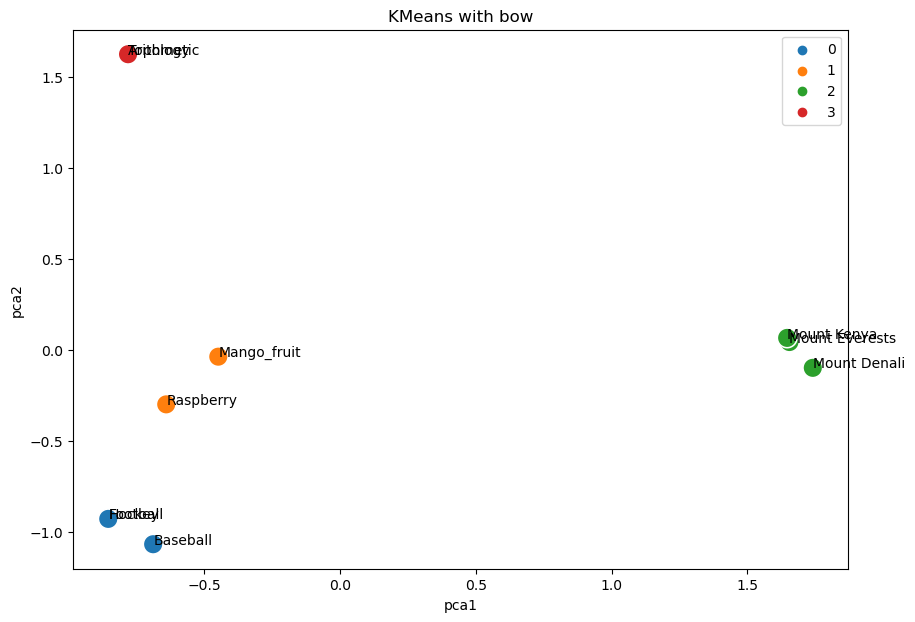

In [68]:
labels = kmeans_bow.labels_
plot_pca_clusters(
    bow_sents, labels, show_labels=True, size=200, title="KMeans with bow"
)

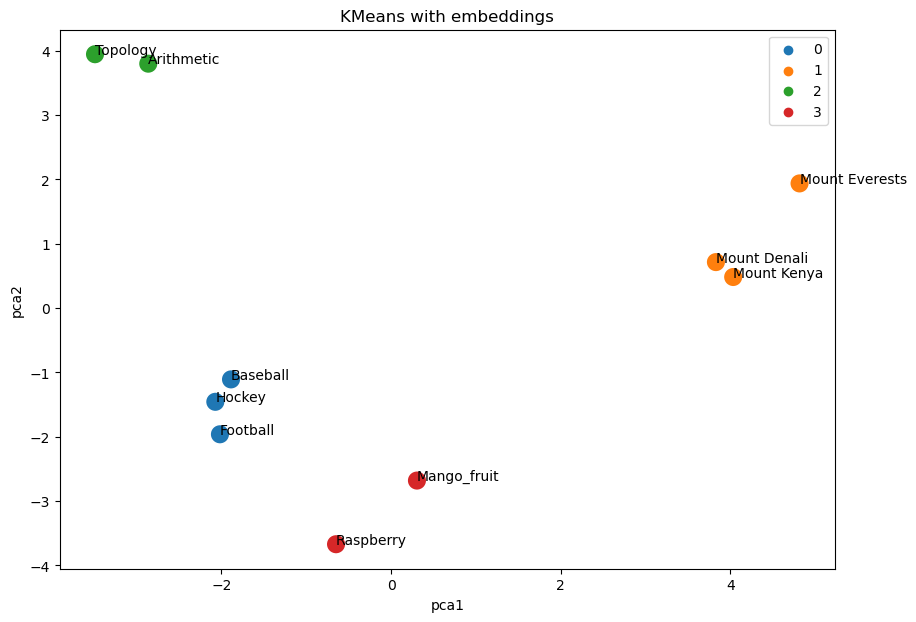

In [69]:
labels = kmeans_emb.labels_
plot_pca_clusters(
    emb_sents, labels, show_labels=True, size=200, title="KMeans with embeddings"
)

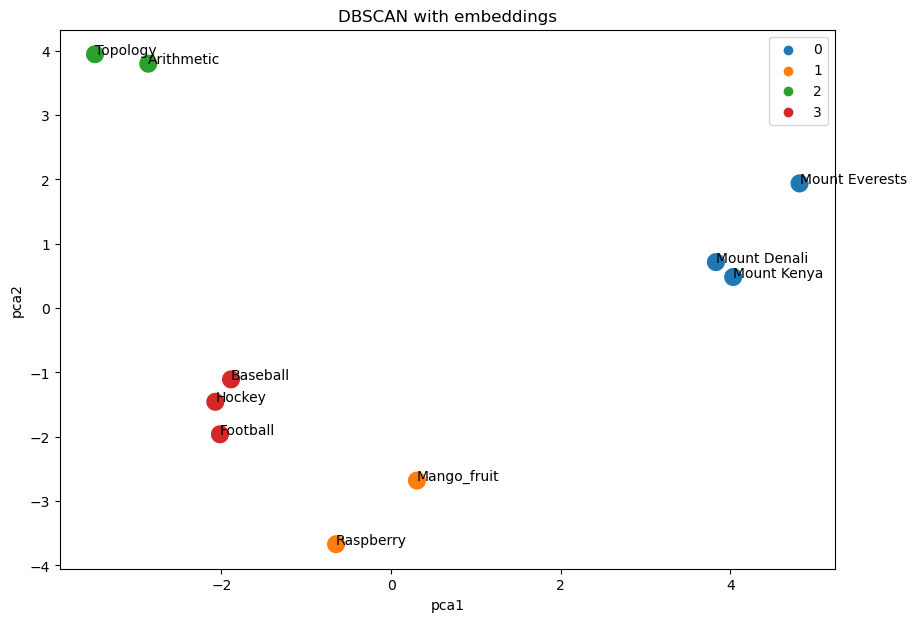

In [70]:
labels = dbscan_emb.labels_
plot_pca_clusters(
    emb_sents, labels, show_labels=True, size=200, title="DBSCAN with embeddings"
)

### END SOLUTION

<br><br><br><br>

## Exercise 2: Movie recommendations
<hr>

Let's build simple movie recommendation systems using the [MovieLens dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset/data). The original source of the data is [here](https://grouplens.org/datasets/movielens/), and the structure of the data is described in the [README](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that comes with it. The code below reads the data as a CSV assuming that it's under `data/ml-100k/` directory under your lab folder. 

In [100]:
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    os.path.join("data", "ml-100k", "u.data"),
    sep="\t",
    names=r_cols,
    encoding="latin-1",
)
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [101]:
# We'll be using these keys later in the starter code
user_key = "user_id"
item_key = "movie_id"

### 2.1 Terminology
rubric={points:6}

Here is some notation we will be using in this lab. 

**Constants**:

 - $N$: the number of users, indexed by $n$
 - $M$: the number of movies, indexed by $m$
 - $\mathcal{R}$: the set of indices $(n,m)$ where we have ratings in the utility matrix $Y$
    - Thus $|\mathcal{R}|$ is the total number of ratings
 - $k$: the number of latent dimensions we use in collaborative filtering
 
**The data**:

 - $Y$: the utility matrix containing ratings, with a lot of missing entries
 - $Z$: a matrix whose rows $z_m$ represent the features for movie $m$ (size $M\times d$).
 - `train_mat` and `valid_mat`: Utility matrices for train and validation sets, respectively
 
    
**Your tasks:**    

1. What are the values of $N$ and $M$ in movie ratings data?  
2. What would be the shape of the dense utility matrix $Y$? 
3. What would be the fraction of observed ratings in the utility matrix $Y$? 

In [102]:
N = None
M = None

### BEGIN SOLUTION

In [103]:
N = len(np.unique(ratings[user_key]))
M = len(np.unique(ratings[item_key]))
print("Number of users (N)                : %d" % N)
print("Number of movies (M)               : %d" % M)

Number of users (N)                : 943
Number of movies (M)               : 1682


The shape of utility matrix is: $N \times M$. In this case it would be 943 by 1682.   

In [104]:
print("Number of ratings (|R|)            : %d" % len(ratings))
print("Fraction of nonzero                : %.1f%%" % (len(ratings) / (N * M) * 100))

Number of ratings (|R|)            : 100000
Fraction of nonzero                : 6.3%


### END SOLUTION

<br><br>

### 2.2 Splitting the data
rubric={accuracy:4}

**Your tasks:**

1. Split the ratings data with `test_size=0.2` and `random_state=42`. 

### BEGIN SOLUTION

In [105]:
from sklearn.model_selection import train_test_split

ratings = ratings.drop(columns="timestamp")
X = ratings.copy()
y = ratings["user_id"]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### END SOLUTION

<br><br>

### 2.3 Utility matrix 
rubric={points:10}

**Your tasks**
1. Create utility matrices for train and validation sets. 
2. Briefly explain the difference between the train and validation utility matrices. 

> You may use the code from lecture notes with appropriate attribution.  

> You won't do it in real life but since our dataset is not that big, create a dense utility matrix in this assignment. You are welcome to try sparse matrix but then you may have to change some started code provided in the later exercises.  

In [106]:
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

### BEGIN SOLUTION

In [107]:
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

### END SOLUTION

In [108]:
train_mat = None
valid_mat = None

### BEGIN SOLUTION

In [109]:
train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)

print("train_mat shape: ", train_mat.shape)
print("valid_mat shape: ", valid_mat.shape)
print("Number of non-nan elements in train_mat: ", np.sum(~np.isnan(train_mat)))
print("Number of non-nan elements in valid_mat: ", np.sum(~np.isnan(valid_mat)))

train_mat shape:  (943, 1682)
valid_mat shape:  (943, 1682)
Number of non-nan elements in train_mat:  80000
Number of non-nan elements in valid_mat:  20000


Both the training utility matrix `train_mat` and validation utility matrix `valid_mat` are of shape N by M but `train_mat` only has the ratings from `X_train`, whereas `valid_mat` only has the ratings from `X_valid` and all other ratings missing. 

### END SOLUTION

<br><br>

### 2.4 Evaluation and baseline
rubric={reasoning:10}

To compare different models you build in this homework, let's write a couple of functions for evaluation. 
- The `error` function returns RMSE.
- The `evaluate` function prints the train and validation RMSEs. 

**Your task:**

1. Briefly explain what exactly we are comparing when evaluating recommender systems. 
2. Implement the global average baseline, where you predict everything as the global average rating. 

In [110]:
def error(Y1, Y2):
    """
    Returns the root mean squared error (RMSE).
    """
    return np.sqrt(np.nanmean((Y1 - Y2) ** 2))


def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))

### BEGIN SOLUTION

When evaluating a recommender system, we first predict ratings in the utility matrix (based on data from the train utility matrix).  Once we have predictions, we:

- Compare predictions with the non-NaN ratings in the train set to get the training root mean squared error (RMSE).
- Compare predictions with the non-NaN ratings in the validation set to get validation RMSE.

RMSE is a standard way to benchmark recommender systems. However, it doesn't necessarily measure what we want in recommender systems. First of all, there is no ground truth in the context of recommender systems. The overall goal is to find items that the user is actually interested in, and along with the rating the user would give to the item, there are many other considerations such as diversity, freshness, and trust, which are not really captured by RMSE. 

In [111]:
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
pd.DataFrame(pred_g).head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
1,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
2,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
3,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
4,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262


In [112]:
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 1.13
Global average valid RMSE: 1.12


### END SOLUTION

<br><br>

### (Optional) 2.5 $k$-nearest neighbours imputation
rubric={points:1}

**Your tasks:**

Try [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to fill in the missing entries. Discuss your observations. 

### BEGIN SOLUTION

In [113]:
from sklearn.impute import KNNImputer

num_neighs = [10, 15, 20, 40]
for n_neighbors in num_neighs:
    print("\nNumber of neighbours: ", n_neighbors)
    imputer = KNNImputer(n_neighbors=n_neighbors)
    pred_knn = imputer.fit_transform(train_mat)          
    keep_cols = ~np.isnan(train_mat).all(axis=0)
    print(keep_cols.shape)
    evaluate(pred_knn, 
             train_mat[:, keep_cols], 
             valid_mat[:, keep_cols], 
             model_name=f"k-nearest neighbours imputation, k={n_neighbors}")


Number of neighbours:  10
(1682,)
k-nearest neighbours imputation, k=10 train RMSE: 0.00
k-nearest neighbours imputation, k=10 valid RMSE: 0.98

Number of neighbours:  15
(1682,)
k-nearest neighbours imputation, k=15 train RMSE: 0.00
k-nearest neighbours imputation, k=15 valid RMSE: 0.97

Number of neighbours:  20
(1682,)
k-nearest neighbours imputation, k=20 train RMSE: 0.00
k-nearest neighbours imputation, k=20 valid RMSE: 0.97

Number of neighbours:  40
(1682,)
k-nearest neighbours imputation, k=40 train RMSE: 0.00
k-nearest neighbours imputation, k=40 valid RMSE: 0.98


The training RMSE is zero here because KNN imputer only imputes missing values. With `n_neighbors = 15 or 20`, we are getting the best validation RMSE so far although the difference between average of per-user and per-movie baseline and this one is not large.

Also, in order for the imputer to work, we had to remove the columns where all entries were NaN because the KNN imputer is not able to find an average of ratings for such columns. We could impute ratings of such columns with the global average similar to how we did it with other baselines.  

### END SOLUTION

<br><br>

### 2.6 Use collaborative filtering with the `surprise` package
rubric={points:10}

Use the [`surprise`](https://surprise.readthedocs.io/en/stable/) package which has implementation of SVD algorithm for collaborative filtering. You can install it as follows in your conda environment. 

```
>> conda activate cpsc330
>> conda install -c conda-forge scikit-surprise
or 
>> pip install scikit-surprise
```

**Your tasks:**

1. Carry out cross-validation using SVD algorithm in the package, similar to how we did it in the lecture on Jester dataset. Report mean RMSE and compare it with global baseline. 

### BEGIN SOLUTION

In [116]:
from surprise import SVD, Dataset, KNNBasic, Reader
from surprise.model_selection import cross_validate

reader = Reader()
data = Dataset.load_from_df(ratings, reader)
trainset = data.build_full_trainset()
algo = SVD()
res = cross_validate(algo, data, measures=["RMSE"], cv=5, verbose=True)
pd.DataFrame(res)

/Users/mathias/miniconda3/envs/cpsc330/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: dev is an invalid version and will not be supported in a future release
  warnings.warn(


Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9368  0.9308  0.9383  0.9333  0.9366  0.9351  0.0027  
Fit time          0.92    0.85    0.85    0.67    0.66    0.79    0.10    
Test time         0.11    0.80    0.10    0.08    0.08    0.23    0.28    


,test_rmse,fit_time,test_time
0,0.936781,0.924784,0.108455
1,0.930804,0.847974,0.803349
2,0.938276,0.850049,0.095153
3,0.933329,0.674935,0.083853
4,0.936551,0.661208,0.080709


In [120]:
pd.DataFrame(res).mean()

test_rmse    0.935148
fit_time     0.791790
test_time    0.234304
dtype: float64

### END SOLUTION

<br><br>

### 2.7 Clustering based recommendation system?
rubric={points:2}

How would you apply `K-Means` clustering to build a recommendation systems? What could be challenging with this approach?

### BEGIN SOLUTION

We could use two different approaches:
- cluster items (based on which users like them), and recommend items in the same clusters as the one a user already like.
- cluster users (based on which items they like), and recommend items that users' in the same cluster liked.

At least two challenges could arise in this approach:
- recommendation data is typically very sparse, and we have seen that `K-Means` struggles with clustering in that case.
- choosing $K$ to have a good trade-off may be difficult: a small $K$ would lead to too many items among which to chose recommendations, while a large $K$ would likely lead to poor clustering.

### END SOLUTION

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 